In [ ]:
# Local clone
! git clone https://github.com/nanopiero/CML_processing_by_ML.git

In [2]:
# Imports
from os.path import join, isdir, isfile
from os import listdir as ls
import copy
import torch
import numpy as np

import sys
sys.path.append('CML_processing_by_ML')

from src.utils.simulation import create_dataloader
import src.utils.architectures_fcn
from src.utils.architectures import load_archi
from src.utils.architectures_fcn import UNet_causal_5mn_atrous, UNet_causal_5mn_atrous_rescale

In [3]:
# Dictionary with pseudo "distances" (distances between two antennnas) for 1,000 pseudo CML ids.
idx2distance = {i: 0.2 +  1.8 * torch.rand((1,)).item() for i in range(0, 1000)}
duration = 4096  # length of the time series
batch_size = 100  # Number of samples per batch
dataloader = create_dataloader(duration, idx2distance, batch_size)

In [4]:
# To pull and reload, if needed:
! cd CML_processing_by_ML ; git pull ; cd ..

import importlib
importlib.reload(src.utils.architectures_fcn)
importlib.reload(src.utils.architectures)
from src.utils.architectures_fcn import  UNet_causal_5mn_atrous_multiplicative_rescale
from src.utils.architectures import  load_archi

Already up to date.


# How to correctly process both 1h and 1min sums ?

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Loss2scales(nn.Module):
    def __init__(self, multitask=True, alpha=1, beta=1/64):
        super(Loss2scales, self).__init__()
        self.criterion = nn.MSELoss()
        self.multitask = multitask
        self.alpha = alpha
        self.beta = beta
    def forward(self, y, z, p=None):
        # Compute MSE1: MSE between y[:, 0] and z
        mse1 = self.criterion(y[:, 0], z[:, 0])

        # Compute MSE64 using convolution
        if y.shape[1] == 1:
            y_channel = y[:, 0].unsqueeze(1)  # Shape: (batch_size, 1, 4096)
        elif y.shape[1] == 2:
            y_channel = y[:, 1].unsqueeze(1)  # Shape: (batch_size, 1, 4096)

        # Create the convolutional kernel for summing over a window of size 64
        kernel = torch.ones(1, 1, 64, device=y.device)

        # Compute y64: convolution with stride of 64
        y64 = F.conv1d(y_channel, kernel, stride=64)
        # Adjust z to match the shape for convolution
        z64 = F.conv1d(z, kernel, stride=64)
        # Compute MSE64
        mse64 = self.criterion(y64, z64)

        # Combine the two losses
        if self.multitask:
            if p is None:
                raise ValueError("Parameter p must be provided for multitask loss computation.")
            # Multi-task loss balancing with the provided parameter p
            loss = (1 / (2 * p[0])) * mse1 + (1 / (2 * 64 * p[1])) * mse64 + torch.log(1 + p[0]**2 + p[1]**2)
        else:
            # Simple combination of the losses
            loss = self.alpha * mse1 + self.beta * mse64

        return loss, mse1, 1/64 * mse64

In [25]:
def training(criterion, num_epochs, dataloader, model, optimizer):

  model.train()
  losses1 = []
  losses64 = []
  for epoch in range(num_epochs):

      running_loss = 0.0
      running_loss1 = 0.0
      running_loss64 = 0.0

      for batch_idx, (idxs, dists, ground_truths, noisy_series) in enumerate(dataloader):
          inputs, targets = noisy_series.to(device), \
                            ground_truths.to(device)

          use_first_network = torch.rand(idxs.shape, device=inputs.device) > 0.75
          idxs[use_first_network] = -1

          # Add the channel's dim
          inputs = inputs.unsqueeze(1)
          targets = targets.unsqueeze(1)

          # Zeroing gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs, idxs.to(device))
          loss, loss1, loss64 = criterion(outputs, targets, model.p)

          # Backward and optimize
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          running_loss1 += loss1.item()
          running_loss64 += loss64.item()

      if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}, Loss: {running_loss1/len(dataloader):.4f}, Loss: {running_loss64/len(dataloader):.4f}')

      losses1.append(running_loss1/len(dataloader))
      losses64.append(running_loss64/len(dataloader))

  return model, losses1, losses64

In [45]:
# constants
arch = "UNet_causal_5mn_atrous_multiplicative_rescale"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nchannels = 1
dilation = 2
atrous_rates=[6, 12, 18]
additional_parameters = 2

num_epochs = 50

Epoch [10/50], Loss: 0.2105, Loss: 0.2105, Loss: 1.6029
Epoch [20/50], Loss: 0.1523, Loss: 0.1523, Loss: 1.3175
Epoch [30/50], Loss: 0.1403, Loss: 0.1403, Loss: 1.1754
Epoch [40/50], Loss: 0.1307, Loss: 0.1307, Loss: 1.0198
Epoch [50/50], Loss: 0.1304, Loss: 0.1304, Loss: 0.9815


Epoch [10/50], Loss: 1.7608, Loss: 0.2774, Loss: 1.4834
Epoch [20/50], Loss: 1.4845, Loss: 0.2539, Loss: 1.2305
Epoch [30/50], Loss: 1.1791, Loss: 0.2417, Loss: 0.9374
Epoch [40/50], Loss: 1.0261, Loss: 0.2317, Loss: 0.7944
Epoch [50/50], Loss: 0.9923, Loss: 0.2197, Loss: 0.7726


Epoch [10/50], Loss: 1.5436, Loss: 0.5689, Loss: 1.5436
Epoch [20/50], Loss: 1.3276, Loss: 0.5256, Loss: 1.3276
Epoch [30/50], Loss: 1.1882, Loss: 0.5447, Loss: 1.1882
Epoch [40/50], Loss: 1.1099, Loss: 0.7521, Loss: 1.1099
Epoch [50/50], Loss: 0.9630, Loss: 1.2468, Loss: 0.9630


Epoch [10/50], Loss: 0.2163, Loss: 0.2163, Loss: 18.8136
Epoch [20/50], Loss: 0.1525, Loss: 0.1525, Loss: 12.7189
Epoch [30/50], Loss: 0.1400, Loss: 0.140

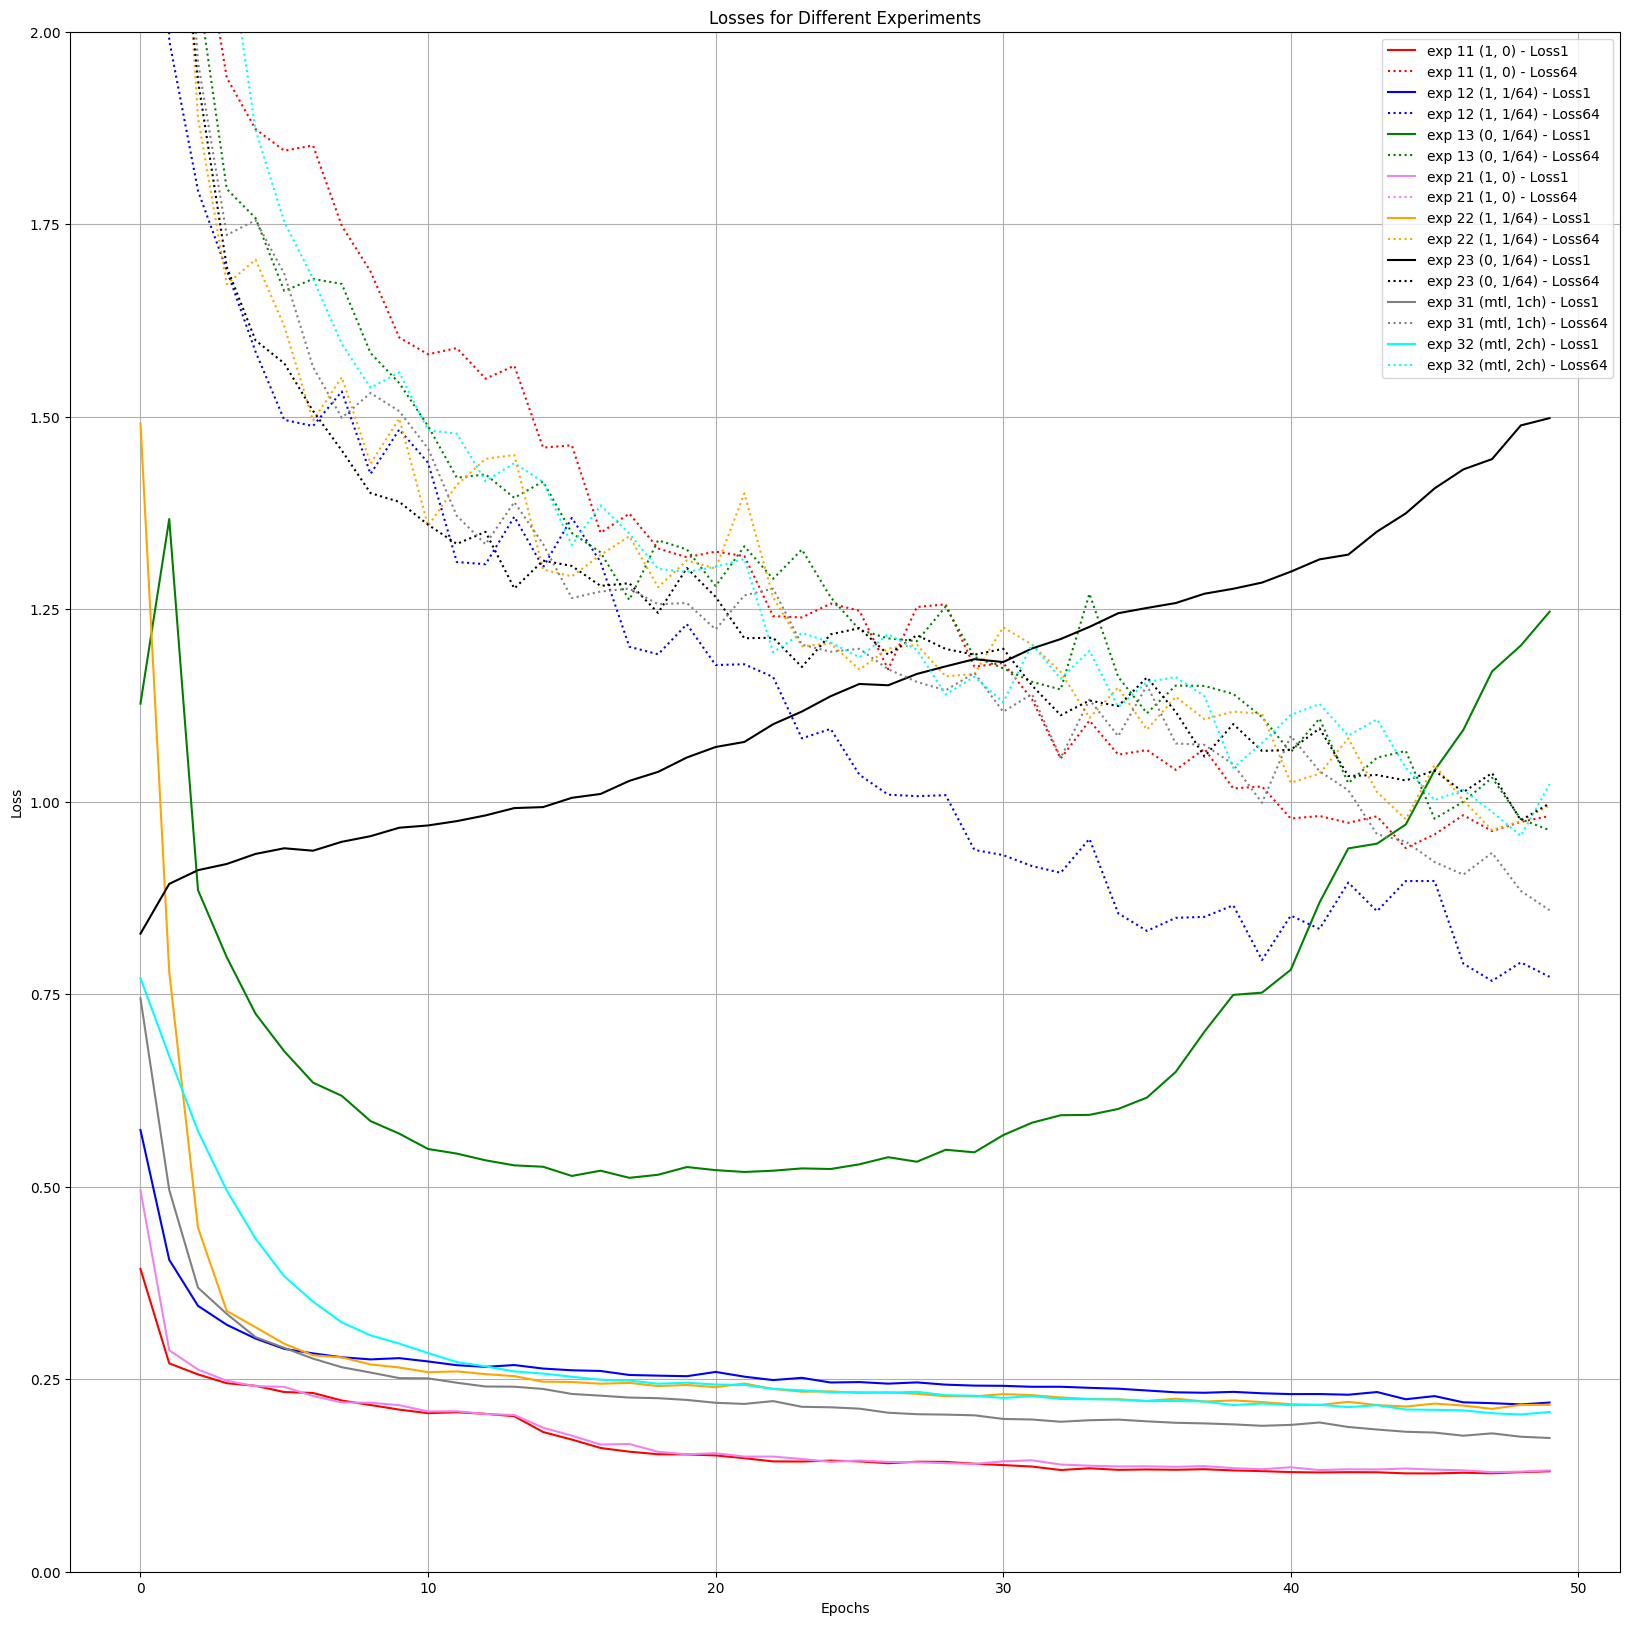

In [46]:
# exp 11: alpha = 1 beta = 0 (no need to optimize cumsums)
criterion = Loss2scales(multitask=False, alpha=1, beta=0)
nclasses = 1
model = load_archi(arch, nchannels, nclasses, size=64, dilation=1,
                   atrous_rates=atrous_rates, fixed_cumul=False,
                   additional_parameters=additional_parameters).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
_, losses1_1_1_0, losses64_1_1_0 = training(criterion, num_epochs, dataloader, model, optimizer)
print('\n')

# exp 12: alpha = 1 beta = 1/64 (no need to optimize cumsums)
criterion = Loss2scales(multitask=False, alpha=1, beta=1/64.)
nclasses = 1
model = load_archi(arch, nchannels, nclasses, size=64, dilation=1,
                   atrous_rates=atrous_rates, fixed_cumul=False,
                   additional_parameters=additional_parameters).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
_, losses1_1_1_64, losses64_1_1_64 = training(criterion, num_epochs, dataloader, model, optimizer)
print('\n')

# exp 13: alpha = 0 beta = 1/64 (no need to optimize cumsums)
criterion = Loss2scales(multitask=False, alpha=0, beta=1/64.)
nclasses = 1
model = load_archi(arch, nchannels, nclasses, size=64, dilation=1,
                   atrous_rates=atrous_rates, fixed_cumul=False,
                   additional_parameters=additional_parameters).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
_, losses1_1_0_64, losses64_1_0_64 = training(criterion, num_epochs, dataloader, model, optimizer)
print('\n')

# exp 21: 2 channels alpha = 1 beta = 0 (no need to optimize cumsums)
criterion = Loss2scales(multitask=False, alpha=1, beta=0)
nclasses = 2
model = load_archi(arch, nchannels, nclasses, size=64, dilation=1,
                   atrous_rates=atrous_rates, fixed_cumul=False,
                   additional_parameters=additional_parameters).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
_, losses1_2_1_0, losses64_2_1_0 = training(criterion, num_epochs, dataloader, model, optimizer)
print('\n')

# exp 22: alpha = 1 beta = 1/64 (no need to optimize cumsums)
criterion = Loss2scales(multitask=False, alpha=1, beta=1/64.)
nclasses = 2
model = load_archi(arch, nchannels, nclasses, size=64, dilation=1,
                   atrous_rates=atrous_rates, fixed_cumul=False,
                   additional_parameters=additional_parameters).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
_, losses1_2_1_64, losses64_2_1_64 = training(criterion, num_epochs, dataloader, model, optimizer)
print('\n')

# exp 23: alpha = 0 beta = 1/64 (no need to optimize cumsums)
criterion = Loss2scales(multitask=False, alpha=0, beta=1/64.)
nclasses = 2
model = load_archi(arch, nchannels, nclasses, size=64, dilation=1,
                   atrous_rates=atrous_rates, fixed_cumul=False,
                   additional_parameters=additional_parameters).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
_, losses1_2_0_64, losses64_2_0_64 = training(criterion, num_epochs, dataloader, model, optimizer)
print('\n')

# exp 31: 1 channels alpha = 0 beta = 0 multitask = True
criterion = Loss2scales(multitask=True, alpha=0, beta=0)
nclasses = 2
model = load_archi(arch, nchannels, nclasses, size=64, dilation=1,
                   atrous_rates=atrous_rates, fixed_cumul=False,
                   additional_parameters=additional_parameters).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
_, losses1_1_mtl, losses64_1_mtl = training(criterion, num_epochs, dataloader, model, optimizer)
print('\n')

# exp 32: 1 channels alpha = 0 beta = 0 multitask = True
criterion = Loss2scales(multitask=True, alpha=0, beta=0)
nclasses = 2
model = load_archi(arch, nchannels, nclasses, size=64, dilation=1,
                   atrous_rates=atrous_rates, fixed_cumul=False,
                   additional_parameters=additional_parameters).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
_, losses1_2_mtl, losses64_2_mtl = training(criterion, num_epochs, dataloader, model, optimizer)
print('\n')


# Dictionary to store the experiment names and their corresponding losses
experiments = {
    'exp 11 (1, 0)': (losses1_1_1_0, losses64_1_1_0),
    'exp 12 (1, 1/64)': (losses1_1_1_64, losses64_1_1_64),
    'exp 13 (0, 1/64)': (losses1_1_0_64, losses64_1_0_64),
    'exp 21 (1, 0)': (losses1_2_1_0, losses64_2_1_0),
    'exp 22 (1, 1/64)': (losses1_2_1_64, losses64_2_1_64),
    'exp 23 (0, 1/64)': (losses1_2_0_64, losses64_2_0_64),
    'exp 31 (mtl, 1ch)': (losses1_1_mtl, losses64_1_mtl),
    'exp 32 (mtl, 2ch)': (losses1_2_mtl, losses64_2_mtl)
}

# List of easily distinguishable colors
colors = ['red', 'blue', 'green', 'violet', 'orange', 'black', 'grey', 'cyan']

# Plotting all the losses
plt.figure(figsize=(20, 20))

for i, (exp_name, (losses1, losses64)) in enumerate(experiments.items()):
    color = colors[i % len(colors)]  # Cycle through the color list
    # Plot losses1 with a solid line using the selected color
    plt.plot(losses1, label=f'{exp_name} - Loss1', linestyle='-', color=color)
    # Plot losses64 with a dotted line using the same color
    plt.plot(losses64, label=f'{exp_name} - Loss64', linestyle=':', color=color)

# Adding titles and labels
plt.title('Losses for Different Experiments')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0,2])
plt.legend()
plt.grid(True)
plt.show()